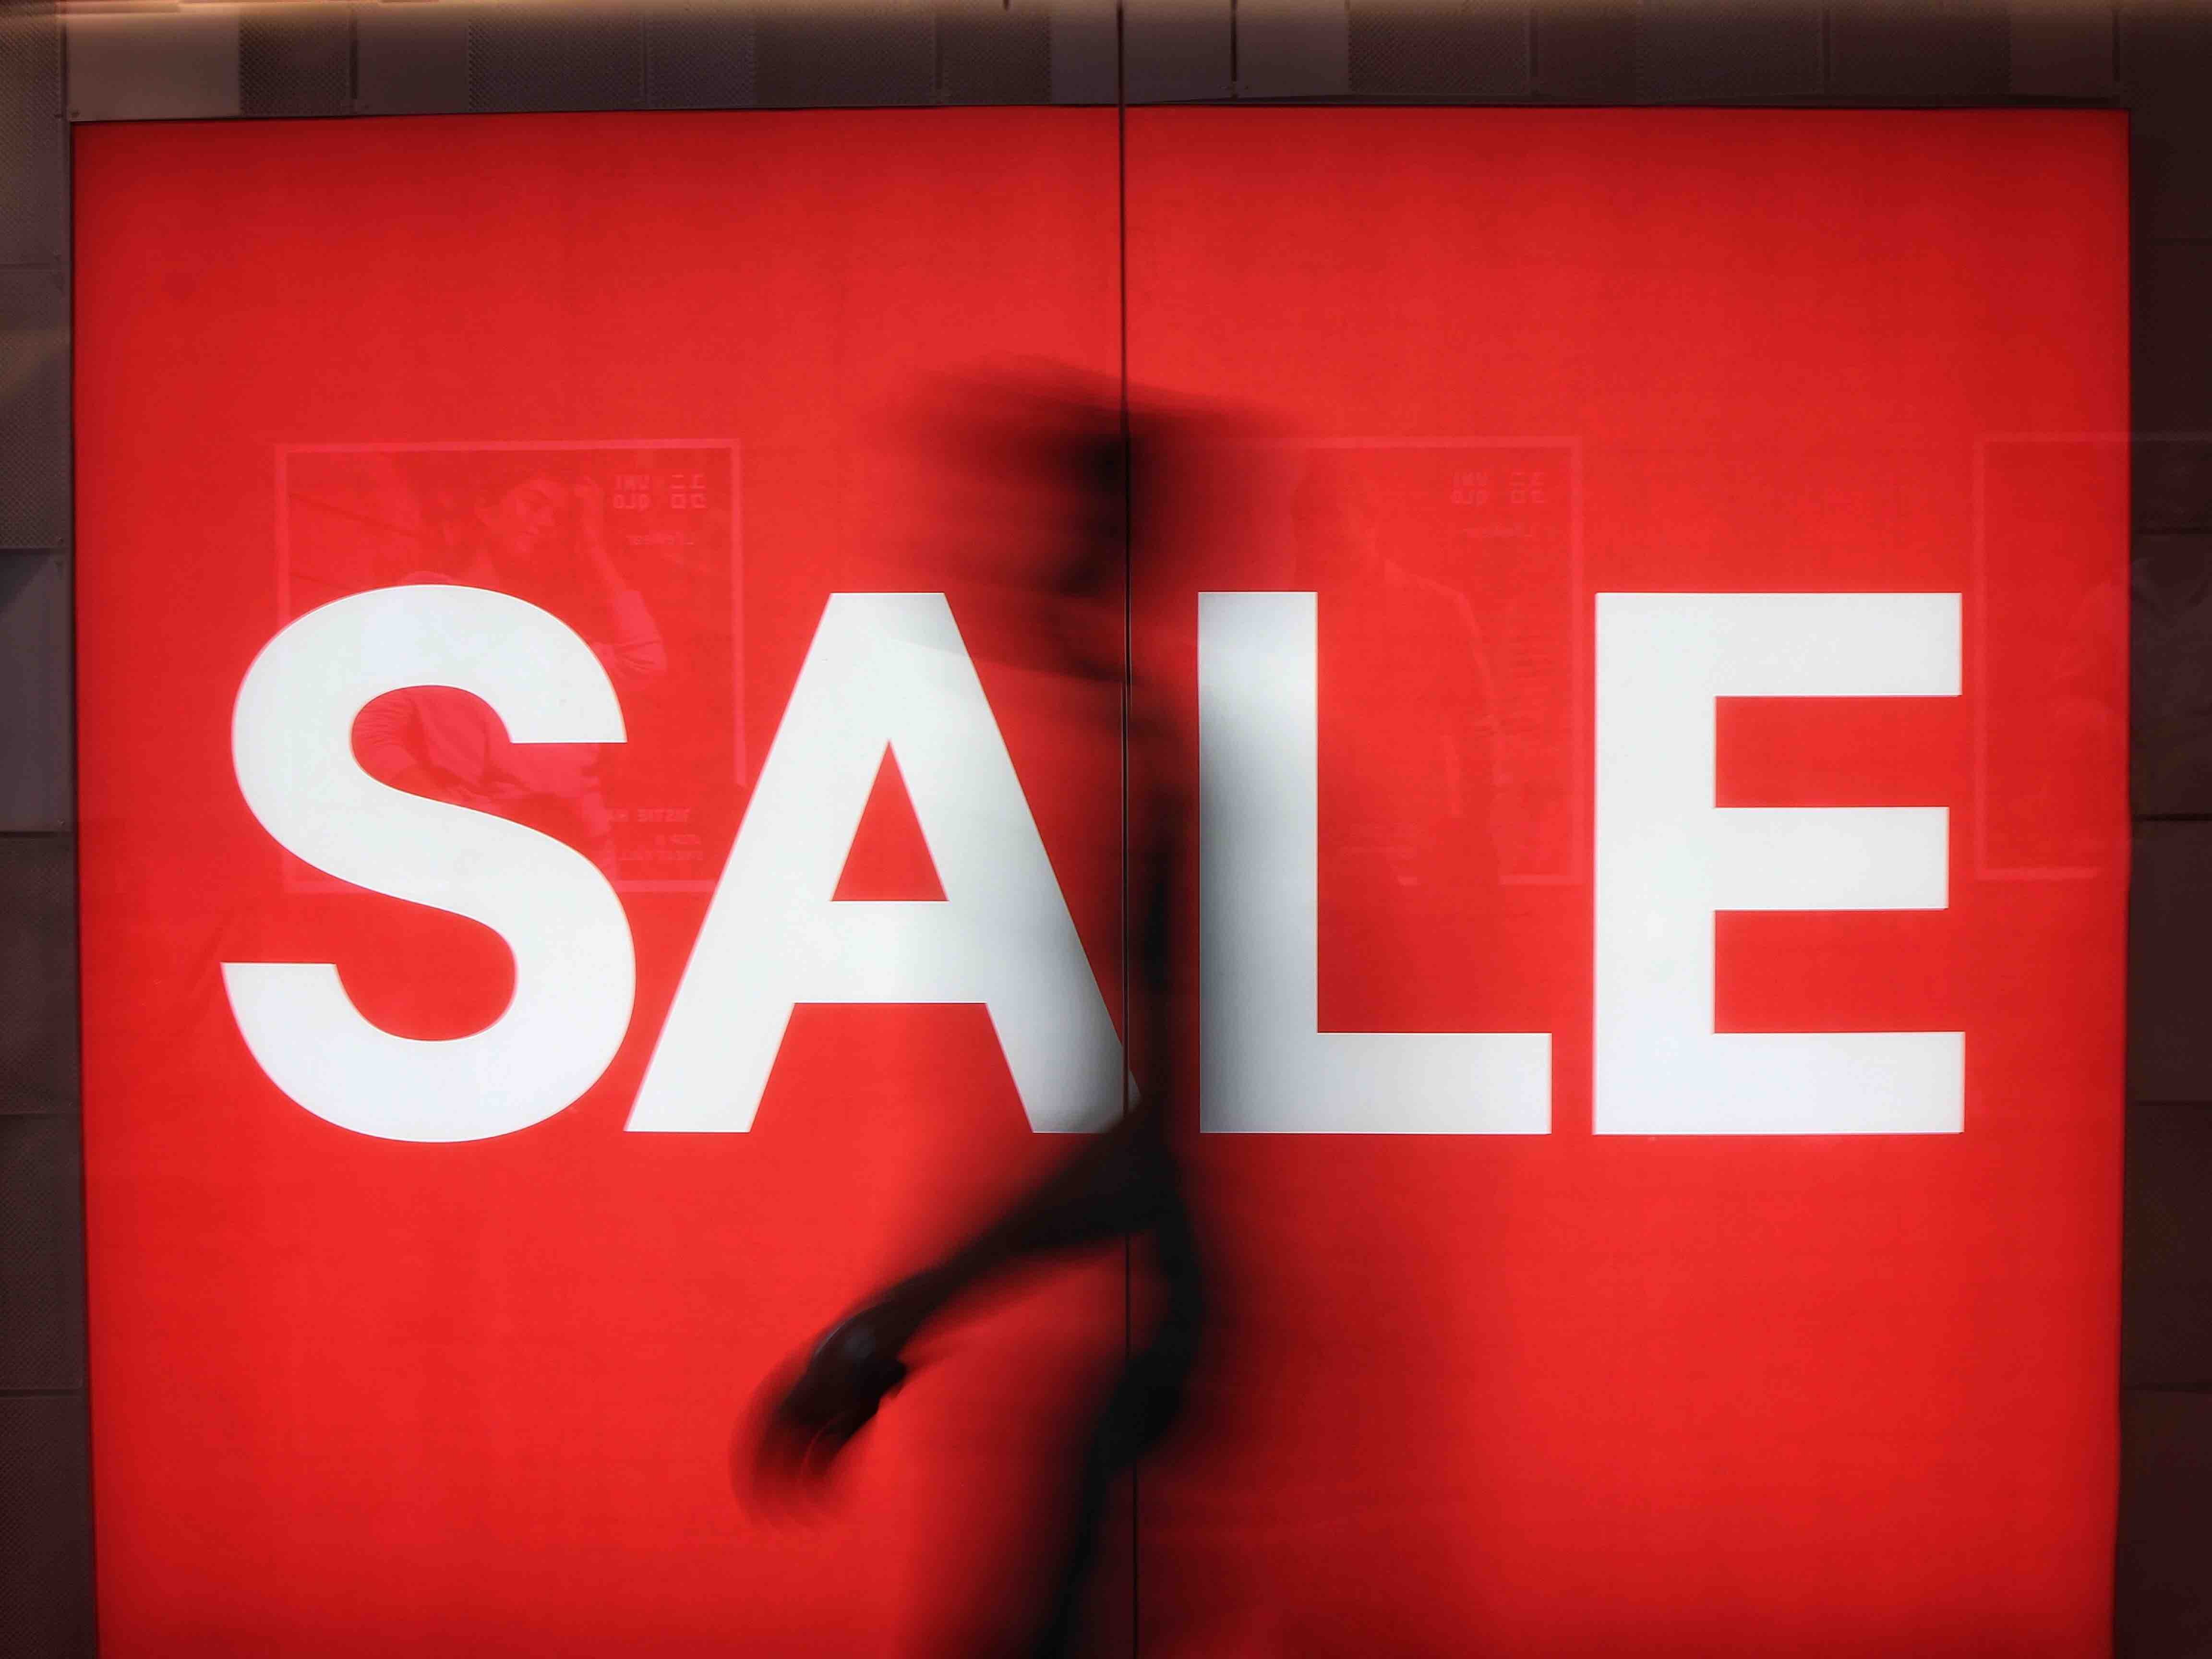
Photo by <a href="https://unsplash.com/@justinlim?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Justin Lim</a> on <a href="https://unsplash.com/?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>
  
<br />

I'm taking How to Win a Data Science Competition: Learn from Top Kagglers course. It was very wonderful and this is that course's final project.

# Flow
1. Most important ingenuity
2. Result
3. Requirements.txt
4. Feature Preprocessing
5. Mean Encording
6. EDA
7. Data Leakgages & Metrics Optimization
8. Generate Dataset
9. Validation
10. Adjust Dataset
11. Ensembles

<br />

## 1. Most important ingenuity
The features which I found and I think are very important are three.

Firstly, I will show the most important ingenuity of my model. It is aligning the train and validation average to the estimated 34 months' mean.

I think important data is sales_train.csv because these data become both input and target value.

First, I check the relationship to test.csv which we should predict and submit has a lot of columns that don't have any past months' sales information from sales_train.csv: approximately 45%. From that, the information of other data such as items, shops, and especially item_categories information (after I add categories transition data, model greatly improved than other data).

Next, I found the amount of sales is decreasing from the first month to last month. The below graph shows the mean item count per month for each month 0~33.

The mean is decreasing, so I want to eliminate the descent because I generate a data set of the transition of each month's sales information to predict the next month. For example, I add 6 months of sales data of the same shop, the same item, the same shop, the same item, and the same category. Thus, this previous information is very important, because the training target may become one years ago data.

Thus, I used LinearRegression from scikit-learn, and I adjusted the data by this program.

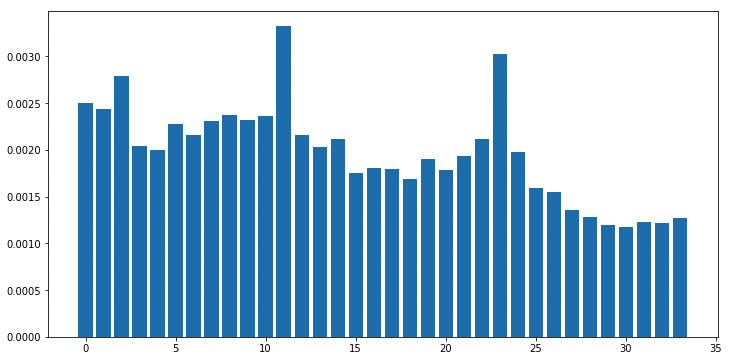

```python
month_means = features[i].loc[:, 0:].mean()
plt.figure(figsize=(12,6))
plt.bar(features[i].loc[:, 0:].columns,month_means)

x = np.array(features[i].loc[:, 0:].columns)
x = x.reshape(-1, 1)
y = np.array(month_means)
y = y.reshape(-1, 1)

# Regression to predict 34 month amm (around month mean)
mm_reg_model = LinearRegression()
mm_reg_model.fit(x,y)

plt.figure(figsize=(12,6))
plt.bar(features[i].loc[:, 0:].columns,month_means)

x = np.concatenate([x, [[34]]], axis=0)
y = mm_reg_model.predict(x)
plt.plot(x, y, linewidth=4, color="red", marker="o")

mm_ratio = np.array(y / y[34])
mm_ratio = mm_ratio[:34]
mm_ratio = mm_ratio.reshape(len(mm_ratio))

plt.figure(figsize=(12,6))
plt.bar(features[i].loc[:, 0:].columns, month_means / mm_ratio)

features[i].loc[:, 0:] = features[i].loc[:, 0:] / mm_ratio
```

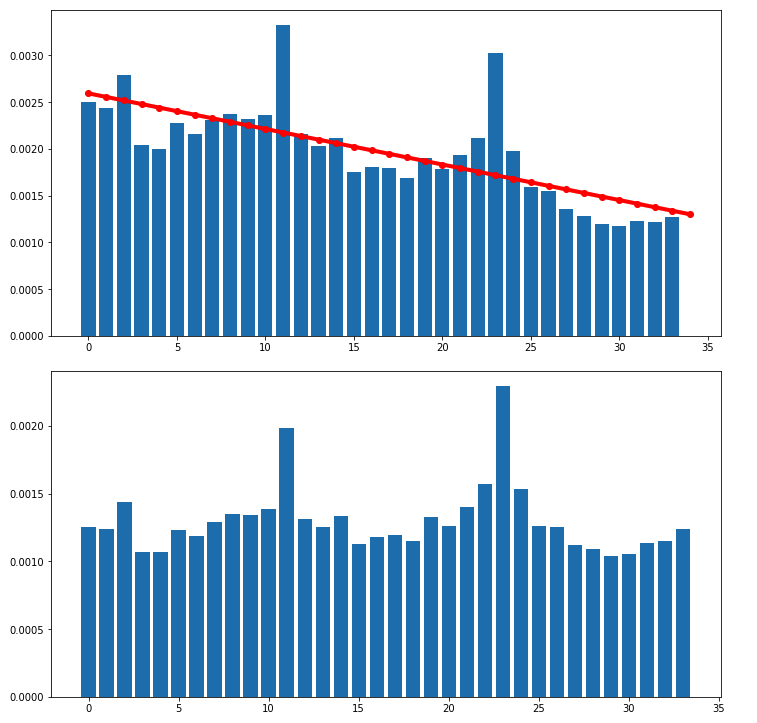

I set 34 months mean prediction which was predicted by linear regression as 1 and aligned columns for each month.

However, a model trained by using that data becomes worse. I think that reason is this information on those changes is important, so I took other approaches.

That approach is estimating 34 months' mean.

After taking the lessons, Metrics optimization, I submit single values predictions many times, to estimate 34 months' correct mean, because I know they used RMSE, so the value which can get the best score is close to the mean of target data. The below list is result.

### **Single value scores**

- 0.2     : 1.220329 and 1.206208.
- 0.25   : 1.217912 and 1.203698.
- 0.3     : 1.217545 and 1.203262.
- 0.35   : 1.219230 and 1.204903.
- 0.4     : 1.222959 and 1.208611.
- 0.5     : 1.23646
- 0.6     : 1.245039 and 1.235736.

The above data is the result, from that I can estimate the mean close to 0.3. Thus, I adjust the train and validation data to close to 0.3.

```python
adj_x_train = np.array(x_train)
adj_y_train = np.array(y_train)
adj_y_train = adj_y_train.clip(0, 20.0 / transition_max)
print(adj_y_train.mean(), adj_y_train.std(), adj_y_train.max())
plt.figure(figsize=(12,6))
plt.hist(np.sqrt(adj_y_train))
# One time delete 0.01%
over_index = np.where(adj_y_train < std_pre_ave)[0]
print(over_index)
print(len(adj_y_train), len(over_index))
drop_rate = 0.035
drop_number = int(len(over_index) * drop_rate) if int(len(over_index) * drop_rate) > 1.0 else 1
print(drop_number)

adj_area = 0.00005
%%time
for i in range(100):
    over_index = np.where(adj_y_train < std_pre_ave)[0]
    np.random.shuffle(over_index)
    drop_index = over_index[:drop_number]
    drop_number = int(drop_number * 0.95)
    
    adj_x_train = np.delete(adj_x_train, drop_index, 0)
    adj_y_train = np.delete(adj_y_train, drop_index)
    if adj_y_train.mean() + adj_area > std_pre_ave:
        break
print(f'Stop i:{i}')
print(adj_y_train.mean(), adj_y_train.std(), adj_y_train.max())
```


# 2. Result
This process of eliminating some columns to close an accurate dataset was good I think.

Version 2 is non adjusted and LB score 1.00716
Version 3 is adjusted but LB socre becomes worse 1.00718

Version 4 is adjusted more and LB score is 1.00637.

It improved very little, so it may be meaningless.

# 3. Requirements.txt
MyApp
sklearn: 0.23.2
LightGBM: 3.2.1
CatBoost: 1.0.0

In [ ]:
!pip freeze > requirements.txt.txt

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import lightgbm as lgb
import catboost
from xgboost import XGBRegressor
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)


from tqdm import tqdm
from itertools import product
from sklearn.model_selection import train_test_split
import seaborn as sns

import sys
import os
import gc
from glob import glob
import pickle
import json
import subprocess
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import StratifiedKFold, train_test_split, RepeatedStratifiedKFold


In [ ]:
DF_CEILING_VALUE = 20000.0
SHOP_CEILING_VALUE = 999999.9
ITEM_CEILING_VALUE = 999999.9

In [ ]:
PATH = '../input/competitive-data-science-predict-future-sales/'

df = pd.read_csv(PATH + 'sales_train.csv')
df_test = pd.read_csv(PATH + 'test.csv')
sample = pd.read_csv(PATH + 'sample_submission.csv')
items = pd.read_csv(PATH + 'items.csv')
shops = pd.read_csv(PATH + 'shops.csv')
item_cats = pd.read_csv(PATH + 'item_categories.csv')

In [ ]:
data_files_names = ["df","df_test","sample","items","shops","item_cats"]
data_files = [df,df_test,sample,items,shops,item_cats]

# 4. Feature Preprocessing

In [ ]:
df_test = df_test.drop('ID', axis=1)

In [ ]:
df

In [ ]:
df.loc[df['item_cnt_day'] < 0.0, 'item_cnt_day'] = 0.0

In [ ]:
df[df['item_cnt_day'] > 100.0]

In [ ]:
df.loc[df['item_cnt_day'] > 100.0, 'item_cnt_day'] = 1.0
len(df[df['item_cnt_day']>10.0])

In [ ]:
df[df['item_cnt_day'] > 10.0]

In [ ]:
df.loc[df['shop_id'] == 57, 'shop_id'] = 0
df.loc[df['shop_id'] == 58, 'shop_id'] = 1
df.loc[df['shop_id'] == 11, 'shop_id'] = 10
df.loc[df['shop_id'] == 40, 'shop_id'] = 39

df_test.loc[df_test['shop_id'] == 57, 'shop_id'] = 0
df_test.loc[df_test['shop_id'] == 58, 'shop_id'] = 1
df_test.loc[df_test['shop_id'] == 11, 'shop_id'] = 10
df_test.loc[df_test['shop_id'] == 40, 'shop_id'] = 39

In [ ]:
df['shop_item_id'] = df['shop_id'].astype('str').str.zfill(2) +  df['item_id'].astype('str').str.zfill(5)
df['item_category_id'] = pd.merge(df, items, on='item_id',how='left')['item_category_id']
df

In [ ]:
df = df.groupby(['date_block_num', 'shop_id','item_id','shop_item_id', 'item_category_id'], as_index=False
        ).agg({'item_cnt_day':'sum'}
        ).rename(columns={'item_cnt_day':'mon_shop_item_cnt'})
df

In [ ]:
# Add shop_item_id to df_test
df_test['shop_item_id'] = df_test['shop_id'].astype('str').str.zfill(2) + df_test['item_id'].astype('str').str.zfill(5)
df_test['item_category_id'] = pd.merge(df_test, items, on='item_id',how='left')['item_category_id']
df_test

In [ ]:
count = 0
df_ids = df['shop_item_id'].unique()
repeat_count = 0
for one_id in df_test['shop_item_id'].sample(1000):
    if one_id in df_ids:
        count += 1
    repeat_count += 1

    if repeat_count > 1000:
        break
print(count / repeat_count)

In [ ]:
plt.figure(figsize=(12,6))
plt.hist(df['mon_shop_item_cnt'])

In [ ]:
df.loc[df['mon_shop_item_cnt'] > 100.0, 'mon_shop_item_cnt'] = 101.0

In [ ]:
print(len(df.loc[df['mon_shop_item_cnt'] > 100.0]), len(df.loc[df['mon_shop_item_cnt'] > 101.0]))

In [ ]:
len(np.unique(np.concatenate([df['shop_item_id'], df_test['shop_item_id']])))

In [ ]:
# Outer -> 520915
transition = pd.DataFrame(np.unique(np.concatenate([df['shop_item_id'], df_test['shop_item_id']])), columns=['shop_item_id'])
for i in range(34):
    transition = pd.merge(transition, df[df['date_block_num']==i].drop(['date_block_num', 'shop_id', 'item_id', 'item_category_id'], axis=1).rename(columns={'mon_shop_item_cnt': i}), on='shop_item_id', how='left')
transition = transition.fillna(0)
transition

In [ ]:
plt.figure(figsize=(12,6))
plt.bar(transition.loc[:, 0:].columns,transition.loc[:, 0:].sum())

In [ ]:
plt.figure(figsize=(12,6))
plt.hist(transition.loc[:, 0:].T.sum())

In [ ]:
# I think these data is too big but not invalid
transition[transition.loc[:, 0:].T.sum() >= 500.0]

In [ ]:
# transition_mean = transition.loc[:, 0:].mean().mean()
# transition_std = transition.loc[:, 0:].std().std()
transition_max = transition.loc[:, 0:].max().max()
transition_max

In [ ]:
std_transition = transition.copy()
std_transition.loc[:, 0:] = (std_transition.loc[:, 0:]) / transition_max
std_transition

In [ ]:
shops.loc[shops['shop_id'] == 57, 'shop_id'] = 0
shops.loc[shops['shop_id'] == 58, 'shop_id'] = 1
shops.loc[shops['shop_id'] == 11, 'shop_id'] = 10
shops.loc[shops['shop_id'] == 40, 'shop_id'] = 39
shops

In [ ]:
shop_df = df.groupby(['date_block_num', 'shop_id'], as_index=False
        ).agg({'mon_shop_item_cnt':'sum'}
        )
shop_transition = pd.DataFrame(shops['shop_id'].unique(), columns=['shop_id'])

for i in range(34):
    shop_transition = pd.merge(shop_transition, shop_df[shop_df['date_block_num']==i].drop('date_block_num', axis=1).rename(columns={'mon_shop_item_cnt': i}), on='shop_id', how='left')
shop_transition = shop_transition.fillna(0)

shop_transition_max = shop_transition.loc[:, 0:].max().max()
shop_transition.loc[:, 0:] = (shop_transition.loc[:, 0:]) / shop_transition_max

shop_transition

In [ ]:
shop_feature = transition.loc[:, ['shop_item_id']].copy()
shop_feature['shop_id'] = shop_feature['shop_item_id'].str[:2].astype(int)
shop_feature

In [ ]:
shop_feature = pd.merge(shop_feature, shop_transition, on='shop_id', how='left')
shop_feature = shop_feature.drop('shop_id', axis=1)
shop_feature

In [ ]:
items

In [ ]:
item_df = df.groupby(['date_block_num', 'item_id'], as_index=False
        ).agg({'mon_shop_item_cnt':'sum'})
item_transition = pd.DataFrame(items['item_id'].unique(), columns=['item_id'])

for i in range(34):
    item_transition = pd.merge(item_transition, item_df[item_df['date_block_num']==i].drop('date_block_num', axis=1).rename(columns={'mon_shop_item_cnt': i}), on='item_id', how='left')
item_transition = item_transition.fillna(0)

item_transition_max = item_transition.loc[:, 0:].max().max()
item_transition.loc[:, 0:] = (item_transition.loc[:, 0:]) / item_transition_max

item_transition

In [ ]:
item_feature = transition.loc[:, ['shop_item_id']].copy()
item_feature['item_id'] = item_feature['shop_item_id'].str[2:].astype(int)
item_feature = pd.merge(item_feature, item_transition, on='item_id', how='left')
item_feature = item_feature.drop('item_id', axis=1)
item_feature

In [ ]:
cats_df = df.groupby(['date_block_num', 'item_category_id'], as_index=False
        ).agg({'mon_shop_item_cnt':'sum'})
cats_transition = pd.DataFrame(cats_df['item_category_id'].unique(), columns=['item_category_id'])
for i in range(34):
    cats_transition = pd.merge(cats_transition, cats_df[cats_df['date_block_num']==i].drop('date_block_num', axis=1).rename(columns={'mon_shop_item_cnt': i}), on='item_category_id', how='left')
cats_transition = cats_transition.fillna(0)

cats_transition_max = cats_transition.loc[:, 0:].max().max()
cats_transition.loc[:, 0:] = (cats_transition.loc[:, 0:]) / cats_transition_max

cats_transition

In [ ]:
cats_feature = transition.loc[:, ['shop_item_id']].copy()
cats_feature['item_id'] = cats_feature['shop_item_id'].str[2:].astype(int)
cats_feature['item_category_id'] = pd.merge(cats_feature, items, on='item_id',how='left')['item_category_id']
cats_feature = pd.merge(cats_feature, cats_transition, on='item_category_id', how='left')
cats_feature = cats_feature.drop(['item_id','item_category_id'], axis=1)
cats_feature

# 5. Mean Encording
I learned add noise will improve dataset quority of mean encording data. Shop and item etc feature are one type of mean encording, so I add noise.

50% data of submit data don't has past sales information. Thus, shop and item features are important. However, the data which has only item and shop data is too big, so I add small noise.

In [ ]:
print(shop_feature.loc[:, 0:].mean().mean(), item_feature.loc[:, 0:].mean().mean())

In [ ]:
shop_feature.loc[:, 0:] += np.random.normal(0, shop_feature.loc[:, 0:].mean().mean() * 0.025, shop_feature.loc[:, 0:].shape)
item_feature.loc[:, 0:] += np.random.normal(0, item_feature.loc[:, 0:].mean().mean() * 0.025, item_feature.loc[:, 0:].shape)
cats_feature.loc[:, 0:] += np.random.normal(0, cats_feature.loc[:, 0:].mean().mean() * 0.025, cats_feature.loc[:, 0:].shape)

In [ ]:
shop_feature

In [ ]:
features = [std_transition, shop_feature, item_feature, cats_feature]

In [ ]:
del shop_feature, item_feature, cats_feature
gc.collect()

# 6. EDA

In [ ]:
# I adjust transition data but not apply.
for i in range(len(features)):
    month_means = features[i].loc[:, 0:].mean()
    plt.figure(figsize=(12,6))
    plt.bar(features[i].loc[:, 0:].columns,month_means)

    x = np.array(features[i].loc[:, 0:].columns)
    x = x.reshape(-1, 1)
    y = np.array(month_means)
    y = y.reshape(-1, 1)

    # Regression to predict 34 month amm (around month mean)
    mm_reg_model = LinearRegression()
    mm_reg_model.fit(x,y)

    plt.figure(figsize=(12,6))
    plt.bar(features[i].loc[:, 0:].columns,month_means)

    x = np.concatenate([x, [[34]]], axis=0)
    y = mm_reg_model.predict(x)
    plt.plot(x, y, linewidth=4, color="red", marker="o")

    mm_ratio = np.array(y / y[34])
    mm_ratio = mm_ratio[:34]
    mm_ratio = mm_ratio.reshape(len(mm_ratio))

    plt.figure(figsize=(12,6))
    plt.bar(features[i].loc[:, 0:].columns, month_means / mm_ratio)


    features[i].loc[:, 0:] = features[i].loc[:, 0:] / mm_ratio

In [ ]:
# I adjust transition data but not apply.
for i in range(len(features)):
    count_zero = (features[0].loc[:, 0:] == 0).sum()
    plt.figure(figsize=(12,6))
    plt.bar(features[i].loc[:, 0:].columns,count_zero)

From this result, I can understand that the frequency of data wasn't changed. Only sales amount is decreasing.

<br />

# 7. Data Leakgages & Metrics Optimization
I write about that at 1.Most important ingenuity.
After leaned about Data Leakages, I want to know features of submission data. Then, from Metics Optimization lectures, I knew submitting by single value can find out mean of submission data, because it used RMSE. Thus, I estimate average is 0.3, so I define variable here.

In [ ]:
pre_ave = 0.3

In [ ]:
std_pre_ave = (pre_ave / transition_max)
print(std_pre_ave, pre_ave, transition_max)

# 8. Validation
This is time seriese dataset. Thus, I used only before 32 months data as trained data. Also, I used target is 33 month dataset as validation.

In [ ]:
# Generate index
index = std_transition.index

train_index = []
val_index = []
test_index = []

train_index = index

In [ ]:
# Get colum which don't has any sales inofrmation for fillna.
std_transition.loc[:20000, 0:].T.sum().sort_values()

In [ ]:
std_transition.loc[18252]

In [ ]:
df_test

In [ ]:
sub_index = pd.DataFrame(std_transition.index, columns=['index'])
sub_index['shop_item_id'] = std_transition['shop_item_id']
sub_index = pd.merge(df_test, sub_index, on='shop_item_id',how='left')
print(sub_index.isna().sum())
sub_index = sub_index.fillna(18252)
sub_index = sub_index['index']
sub_index

In [ ]:
val_index = train_index
val_index

# 9. Generate Dataset
By making class, I can generate dataset very easy.

In [ ]:
class WindowGenerator():
    def __init__(self, start_month, last_target_month, input_width, train_index=train_index, val_index=val_index, test_index=test_index, sub_index=sub_index, features=features):
        self.start_month = start_month
        self.last_target_month = last_target_month
        
        # Work out the window parameters.
        self.input_width = input_width
        # It includes y value
        self.total_width = input_width + 1
        
        # Store the raw data.
        self.train_index = train_index
        self.val_index = val_index
        self.test_index = test_index
        self.sub_index = sub_index
        
        # Fixed
        self.features = features
        self.features_number = len(features)
        
        self.repeat_number = self.last_target_month - self.start_month - self.input_width
    def __repr__(self):
        return '\n'.join([
            f'Start month: {self.start_month}',
            f'Input window size: {self.input_width}',
            f'last_target_month: {self.last_target_month}',
            
            f'repeat_number: {self.repeat_number}',
            
            f'features_number: {self.features_number}',
        ])
    
    def generate_window(self, features_lists, index_i, start_point):
        one_window = []
        for window_i in range(self.input_width):
            one_features = []
            for feature_i in range(self.features_number):
                # Array start zero, so I plus 1 to start point.
                one_features.append(features_lists[feature_i][index_i][start_point + 1 + window_i])
            one_window.append(one_features)

        return one_window
    
    def generate_list(self, index):
        x_data = []
        y_data = []
        
        index_number = len(index)
        features_lists = [feature.loc[index].drop('shop_item_id', axis=1).to_numpy().tolist() for feature in features]
        
        reduce = 0
        
        # (batch, time, features)
        for index_i in range(index_number):
            for time_i in range(self.repeat_number):
                start_point = self.start_month + time_i
                one_y = features_lists[0][index_i][start_point + self.total_width]
                
#                 # Data whose target is 0 is very big, so I reduce harf. Even if after that, y mean is 0.2, so I should extract more.
#                 if self.repeat_number > 2:
#                     if one_y == 0:
#                         if np.random.rand() < 0.5:
#                             continue
                
                one_window = self.generate_window(features_lists, index_i, start_point)
                
                x_data.append(one_window)
                y_data.append(one_y)

        return x_data, y_data
    def generate_sub_x(self):
        features_lists = [feature.loc[self.sub_index].drop('shop_item_id', axis=1).to_numpy().tolist() for feature in features]
        index_number = len(self.sub_index)
        
        # start_point + self.total_width = 34
        start_point = 34 - self.total_width
        
        sub_x = []
        # (batch, time, features)
        for index_i in range(index_number):
             sub_x.append(self.generate_window(features_lists, index_i, start_point))
                
        return sub_x
    
    def make_dataset(self, index):
        x_data, y_data = self.generate_list(index)
        return tf.Dataset.from_tensor_slices((x_data, y_data))

    def train_list(self):
        return self.generate_list(self.train_index)

    def val_list(self):
        return self.generate_list(self.val_index)

    def test_list(self):
        return self.generate_list(self.test_index)
    
    
    @property
    def train(self):
        return self.make_dataset(self.train_index)

    @property
    def val(self):
        return self.make_dataset(self.val_index)

    @property
    def test(self):
        return self.make_dataset(self.test_index)


In [ ]:
input_width = 6

train_window = WindowGenerator(
    start_month = 20 - (input_width + 1),
    last_target_month = 32,
    input_width = input_width,
)
train_window

In [ ]:
val_window = WindowGenerator(
    start_month = 33 - (input_width + 1),
    last_target_month = 33,
    input_width = input_width,
)
val_window

# 10. Adjust Dataset
After generating dataset from above class by separate train and val by 10. Vlidation method, I eliminate some data less than estimated 34 months average.

In [ ]:
%%time
x_train, y_train = train_window.train_list()

In [ ]:
%%time
x_val, y_val = val_window.val_list()

In [ ]:
adj_x_train = np.array(x_train)
adj_y_train = np.array(y_train)
adj_y_train = adj_y_train.clip(0, 20.0 / transition_max)
print(adj_y_train.mean(), adj_y_train.std(), adj_y_train.max())

In [ ]:
plt.figure(figsize=(12,6))
plt.hist(np.sqrt(adj_y_train))

In [ ]:
# One time delete 0.01%
over_index = np.where(adj_y_train < std_pre_ave)[0]
print(over_index)
print(len(adj_y_train), len(over_index))
drop_rate = 0.035
drop_number = int(len(over_index) * drop_rate) if int(len(over_index) * drop_rate) > 1.0 else 1
print(drop_number)

adj_area = 0.00005

In [ ]:
%%time
for i in range(100):
    over_index = np.where(adj_y_train < std_pre_ave)[0]
    np.random.shuffle(over_index)
    drop_index = over_index[:drop_number]
    drop_number = int(drop_number * 0.95)
    
    adj_x_train = np.delete(adj_x_train, drop_index, 0)
    adj_y_train = np.delete(adj_y_train, drop_index)
    if adj_y_train.mean() + adj_area > std_pre_ave:
        break
print(f'Stop i:{i}')
print(adj_y_train.mean(), adj_y_train.std(), adj_y_train.max())

In [ ]:
adj_x_val = np.array(x_val)
adj_y_val = np.array(y_val)
adj_y_val = adj_y_val.clip(0, 20.0 / transition_max)
print(adj_y_val.mean(), adj_y_val.std(), adj_y_val.max())

In [ ]:
plt.figure(figsize=(12,6))
plt.hist(np.sqrt(adj_y_val))

In [ ]:
# One time delete 0.01%
over_index = np.where(adj_y_val < std_pre_ave)[0]
print(over_index)
print(len(adj_y_val), len(over_index))
drop_rate = 0.02
drop_number = int(len(over_index) * drop_rate) if int(len(over_index) * drop_rate) > 1.0 else 1
print(drop_number)

adj_area = 0.00005

In [ ]:
%%time
for i in range(100):
    over_index = np.where(adj_y_val < std_pre_ave)[0]
    np.random.shuffle(over_index)
    drop_index = over_index[:drop_number]
    drop_number = int(drop_number * 0.95)
    
    adj_x_val = np.delete(adj_x_val, drop_index, 0)
    adj_y_val = np.delete(adj_y_val, drop_index)
    if adj_y_val.mean() + adj_area > std_pre_ave:
        break
print(f'Stop i:{i}')
print(adj_y_val.mean(), adj_y_val.std(), adj_y_val.max())

In [ ]:
plt.figure(figsize=(12,6))
plt.hist(np.sqrt(adj_y_val))

In [ ]:
del x_train, y_train, x_val, y_val

In [ ]:
def flatten_x(x):
    flat_row = []
    for one_row in x:
        temp_flat_row = []
        for feature_set in one_row:
            for one_feature in feature_set:
                temp_flat_row.append(one_feature)
        flat_row.append(temp_flat_row)
        
    return flat_row

In [ ]:
adj_x_train = flatten_x(adj_x_train)
adj_x_val = flatten_x(adj_x_val)

# 11. Ensemble
I did hyperparameter tuning. I ensemble three types of gradient boost models.

In [ ]:
models = []

In [ ]:
lgb_train = lgb.Dataset(adj_x_train, adj_y_train, free_raw_data=False)
lgb_val = lgb.Dataset(adj_x_val, adj_y_val, reference=lgb_train, free_raw_data=False)


lgbm_params = {
    'objective': 'mse',
    'metric': 'rmse',
    "num_leaves": 500,
    'is_unbalance':True,
    'boosting':'gbdt',
    "learning_rate": 0.01,
    'num_boost_round': 10000,
    'early_stopping_rounds':200
}
model = lgb.train(lgbm_params,
                  lgb_train,
                  valid_names=['train', 'valid'],
                  valid_sets=[lgb_train, lgb_val],
                  early_stopping_rounds=20,
                  verbose_eval=100)

model.save_model(f'./lgb_model')
models.append(model)


In [ ]:
model = catboost.CatBoostRegressor(
    iterations=700,
    learning_rate=0.02,
    depth=12,
    eval_metric='RMSE',
    random_seed = 23,
    bagging_temperature = 0.2,
    od_type='Iter',
    metric_period = 75,
    od_wait=100
)

model.fit(
    adj_x_train,
    adj_y_train, 
    eval_set=(adj_x_val,adj_y_val),
)

model.save_model(f'./cat_model')
models.append(model)

In [ ]:
model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42,
)
model.fit(
    adj_x_train,
    adj_y_train, 
    eval_metric="rmse", 
    eval_set=[(adj_x_val, adj_y_val)], 
    verbose=True, 
    early_stopping_rounds = 10
)
model.save_model(f'./xgb_model')
models.append(model)

In [ ]:
# Gradient boosting models
sub_x = train_window.generate_sub_x()
sub_x = flatten_x(sub_x)

preds = np.zeros(len(sub_x))
for model in models:
    preds = preds + model.predict(sub_x)
preds = preds / len(models)

In [ ]:
# preds = model.predict(sub_x)
preds = preds * transition_max
preds = preds.clip(0.0, 20.0)

In [ ]:
print(preds.mean(), preds.std(), preds.max())

In [ ]:
plt.figure(figsize=(12,6))
plt.hist(preds,bins=50)

In [ ]:
plt.figure(figsize=(12,6))
plt.hist(preds[(preds>0.0) & (preds<1.0)],bins=50)

In [ ]:
sample['item_cnt_month'] = preds
sample.to_csv('submission.csv', index=False)

In [ ]:
sample.head(50)